In [1]:
import sys
from argparse import ArgumentParser
from datasets import InitialConditionDataset, PDEDataset, derivatives

sys.path.append('../..')
import PINNFramework as pf

Was not able to import Horovod. Thus Horovod support is not enabled


In [2]:
import os
import h5py
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%run ukd_matrix_hpm.py --epochs 500 --use_wandb 1 --path_data /home/zhdano82/hpmtraining/data/ --batch_size 512 --num_batches 30000 --num_t 1000 --t_step 1 --learning_rate 1e-5

In [3]:
data_info = {
    "path_data": "/home/zhdano82/hpmtraining/data/",
    "num_t": 1000,
    "t_step": 10,
    "pix_step": 100,
    "num_x": 640,
    "num_y": 480,
    "t_min": InitialConditionDataset.load_frame("/home/zhdano82/hpmtraining/data/", 0)[1].item(),
    "t_max": InitialConditionDataset.load_frame("/home/zhdano82/hpmtraining/data/", 1000)[1].item(),
    "spat_res": 0.3
}

In [4]:
ic_dataset = InitialConditionDataset(
    data_info, 480*640, 100, True)
initial_condition = pf.InitialCondition(ic_dataset)

In [5]:
low_bound = ic_dataset.low_bound.cpu()
up_bound = ic_dataset.up_bound.cpu()
k_values = Variable(0.1*torch.ones([data_info['num_x'],data_info['num_y']]))
"""
alpha_net = pf.models.MLP(input_size=3,
                          output_size=1,
                          hidden_size=500,
                          num_hidden=8,
                          lb=low_bound,
                          ub=up_bound)
"""
# Heat source model - part of du/dt that cannot be explained by conduction
# Input: spatiotemporal coordinates of a point x,y,t
# Output: heat source value for the point
heat_source_net = pf.models.MLP(input_size=3,
                                output_size=1,
                                hidden_size=500,
                                num_hidden=8,
                                lb=low_bound,
                                ub=up_bound)
# PINN model
# Input: spatiotemporal coordinates of a point x,y,t
# Output: temperature u at the point
model = pf.models.MLP(input_size=3,
                      output_size=1,
                      hidden_size=500,
                      num_hidden=8,
                      lb=low_bound,
                      ub=up_bound)

model.cuda()
# HPM model: du/dt = alpha*(u_xx + u_yy) + heat_source
# Initialization: alpha model, heat source model
# Forward pass input: output of the derivatives function for a point x,y,t
# Forward pass output: du/dt value for the point
k_values = k_values.cuda()
#alpha_net.cuda()
heat_source_net.cuda()
#hpm_model = pf.models.MultiModelHPM(alpha_net, heat_source_net)
hpm_model = pf.models.MatrixHPM(k_values, heat_source_net)

In [6]:
model.load_state_dict(torch.load("./best_model_pinn.pt"))

<All keys matched successfully>

In [ ]:
import math
import torch
from torch.autograd.functional import jacobian

In [ ]:
i = torch.rand(512,8).cuda()
i.requires_grad = True

In [ ]:
%%time
J1 = jacobian(hpm_model, i)

In [ ]:
J1[:,:,1].sum()

In [ ]:
J1.squeeze(1).sum(0).T[1].sum()

In [ ]:
%%time
J2 = jacobian(hpm_model.heat_source_net, i[:,:2])

In [ ]:
J2[:,:,:,1].sum()

In [ ]:
from datasets import derivatives

In [ ]:
derivatives(i, model)

In [ ]:
jacobian

In [ ]:
J2.squeeze(1).sum(0).T[1].sum()

In [ ]:
J1[:,:,:,1].sum()

In [7]:
hpm_model.load_state_dict(torch.load("./best_model_hpm.pt"))

<All keys matched successfully>

In [8]:
torch.load("./best_model_hpm.pt")['k_values'].min()

tensor(0.0895, device='cuda:0')

In [35]:
k_values = torch.load("./best_model_hpm.pt")['k_values'].detach().cpu().numpy()

In [33]:
k_values[k_values == 0.1] =0

Text(0.5, 1.0, 'K')

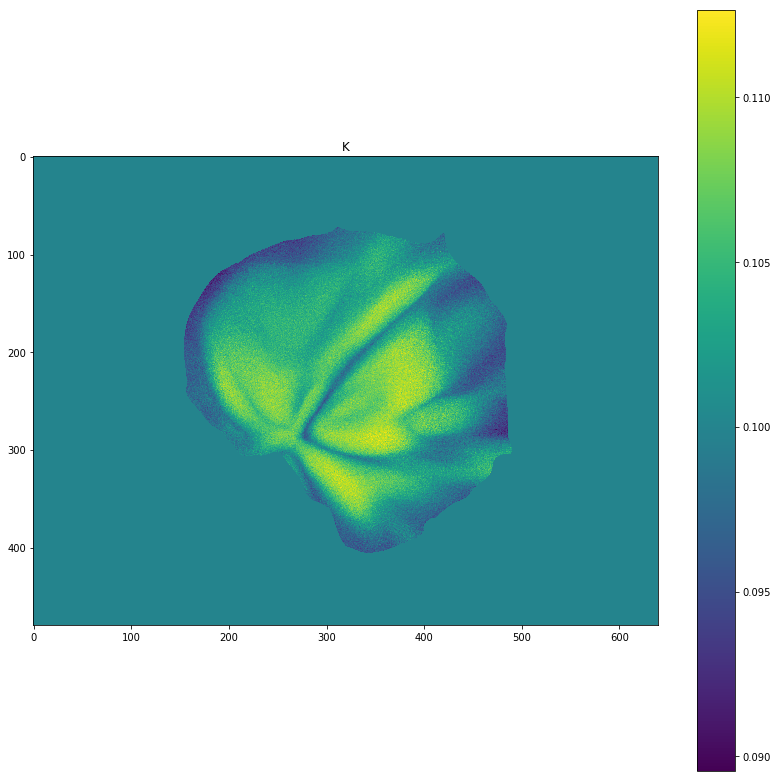

In [36]:
plt.figure(figsize=[14,14])
plt.imshow(k_values.T)
plt.colorbar()
plt.title("K")

In [12]:
def get_2d_grid(num_x, num_y):
    """
    Create a vector with all postions of a 2D grid (nx X ny )
    """
    x_values = np.arange(0, num_x, 1)
    y_values = np.arange(0, num_y, 1)

    x_grid, y_grid = np.meshgrid(x_values, y_values)

    pos_x = x_grid.reshape(-1)
    pos_y = y_grid.reshape(-1)

    return pos_x, pos_y 

def get_input(t_point, path_data, num_x, num_y, spat_res):
    """
    get the input for a specifiy point t 
    this function returns a list of grid points appended with time t
    """
    hf = h5py.File(path_data + str(t_point) + '.h5', 'r')
    t_values = np.array(hf['timing'][0])
    hf.close()

    pos_x, pos_y = get_2d_grid(num_x, num_y)

    size = pos_x.shape[0]
    pos_t = np.zeros(size) + t_values

    val_x = pos_x*spat_res
    val_y = pos_y*spat_res

    return val_x, val_y, pos_t, pos_x, pos_y

In [13]:
mask = ic_dataset.segmentation(
        data_info["path_data"],
        0,
        data_info["num_x"],
        data_info["num_y"]).T

In [14]:
def make_snapshots(t_point):
    x_values,y_values,t_values,x_indices,y_indices= torch.tensor(get_input(t_point, data_info['path_data'], data_info['num_x'], data_info['num_y'], data_info['spat_res']))
    X = torch.stack([x_values, y_values, t_values,x_indices,y_indices], 1).cuda().float()
    #image_hpm = np.zeros(0)
    #image_alpha = np.zeros(0)
    image_hs = np.zeros(0)
    #deriv_sum = np.zeros(0)
    #image = model(X)
    for i in range((480*640)//512):
        X_ = X[i*512:(i+1)*512,:]
        X_.requires_grad = True
        #prediction_u = model(X_)
        #hpm_input = derivatives(X_, prediction_u)
        #time_derivative = hpm_input[:, -1]
        #input = hpm_input[:, :-1]
        #hpm_output = hpm_model(input)
        #deriv_sum = np.append(deriv_sum, (hpm_input.T[4,:]+hpm_input.T[5,:]).cpu().detach().numpy())
        #image_hpm = np.append(image_hpm, hpm_model(hpm_input).cpu().detach().numpy())
        #image_alpha = np.append(image_alpha, alpha_net(hpm_input[:,:3]).cpu().detach().numpy())
        image_hs = np.append(image_hs, heat_source_net(X[:,:3]).cpu().detach().numpy())
        
    #image = image.reshape(480,640).cpu().detach().numpy()*mask
    #image_alpha = (0.1 + 0.05 * np.tanh(image_alpha)).reshape(480,640) *mask
    image_hs = image_hs.reshape(480,640)*mask
    #image_hpm = image_hpm.reshape(480,640)*mask
    #image_diff = (deriv_sum.reshape(480,640)*image_alpha)
    return image_hs #image, image_alpha, image_hs, image_hpm#, image_diff

In [ ]:
image_hs = make_snapshots(500)

KeyboardInterrupt: 

In [ ]:
x_values,y_values,t_values= torch.tensor(get_input(100, data_info['path_data'], data_info['num_x'], data_info['num_y'], data_info['spat_res']))
X = torch.stack([x_values, y_values, t_values], 1).cuda().float()

In [ ]:
plt.imshow(image)
plt.colorbar()
plt.title('u predicted');

In [ ]:
plt.imshow(image_hpm)
plt.colorbar()
plt.title('du/dt predicted');

In [ ]:
plt.imshow(image_alpha)
plt.colorbar()
plt.title('thermal diffusivity predicted');

In [44]:
image, image_alpha, image_hs, image_hpm = make_snapshots(900)

In [27]:
snapshots = []
for i in range(0,100,5):
    x_values,y_values,t_values,_,_ = torch.tensor(get_input(i, data_info['path_data'], data_info['num_x'], data_info['num_y'], data_info['spat_res']))
    X = torch.stack([x_values, y_values, t_values], 1).cuda().float()
    image_hs = heat_source_net(X[:,:3]).cpu().detach().numpy()
    image_hs = (image_hs.reshape(480,640)*mask).reshape(-1)
    snapshots.append(image_hs)
for i in range(100,500,25):
    x_values,y_values,t_values,_,_ = torch.tensor(get_input(i, data_info['path_data'], data_info['num_x'], data_info['num_y'], data_info['spat_res']))
    X = torch.stack([x_values, y_values, t_values], 1).cuda().float()
    image_hs = heat_source_net(X[:,:3]).cpu().detach().numpy()
    image_hs = (image_hs.reshape(480,640)*mask).reshape(-1)
    snapshots.append(image_hs)
for i in range(500,1000,100):
    x_values,y_values,t_values,_,_ = torch.tensor(get_input(i, data_info['path_data'], data_info['num_x'], data_info['num_y'], data_info['spat_res']))
    X = torch.stack([x_values, y_values, t_values], 1).cuda().float()
    image_hs = heat_source_net(X[:,:3]).cpu().detach().numpy()
    image_hs = (image_hs.reshape(480,640)*mask).reshape(-1)
    snapshots.append(image_hs)

In [30]:
snapshots = np.array(snapshots)

In [31]:
np.savetxt('hs.txt', snapshots)

Text(0.5, 1.0, 'heat source predicted')

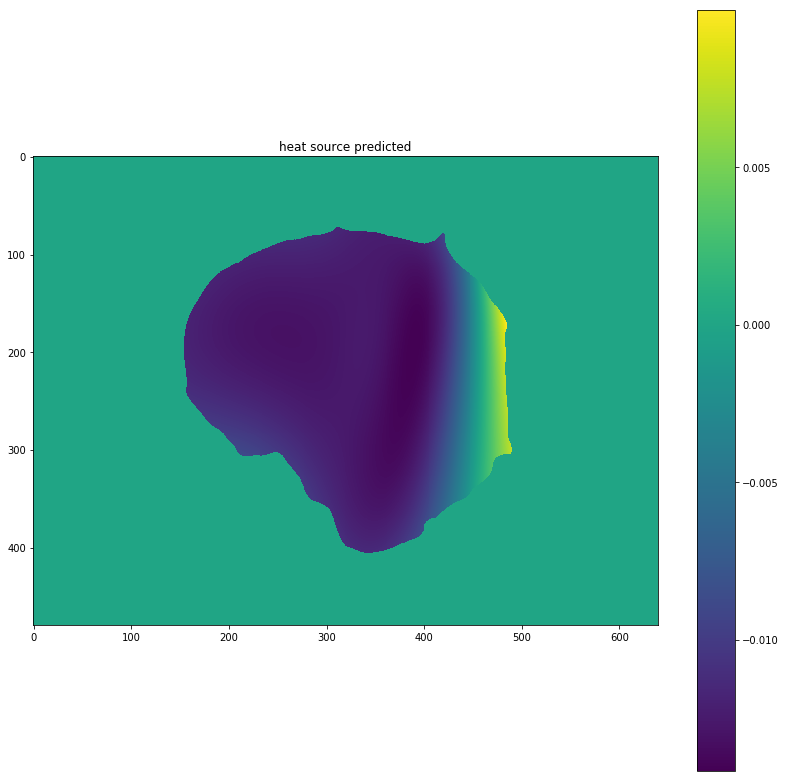

In [20]:
plt.figure(figsize=[14,14])
plt.imshow(image_hs.reshape(480,640)*mask)
plt.colorbar()
plt.title('heat source predicted')

In [ ]:
list(hpm_model.parameters())

In [ ]:
plt.imshow(image_diff)
plt.colorbar()
plt.title('diffusion term predicted')